In [45]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from src.funs import plot_history_plus

## Load Data

In [46]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    'imdb_reviews/plain_text',
    split=['train', 'test[:50%]', 'test[50%:]'],
    as_supervised=True,
    with_info=True
)
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/Users/zewen/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=

---
## Initial Data Analysis

In [47]:
# Iterate over the first 3 samples in the dataset
for x, y in dataset_train_original.take(3):
  # Convert the text data to a string and print it
  print(x.numpy().decode('utf-8'))
  # Print the label for the current sample (either 0 or 1)
  print(y.numpy())


This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was co

2023-02-12 17:25:36.689059: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Lengths 

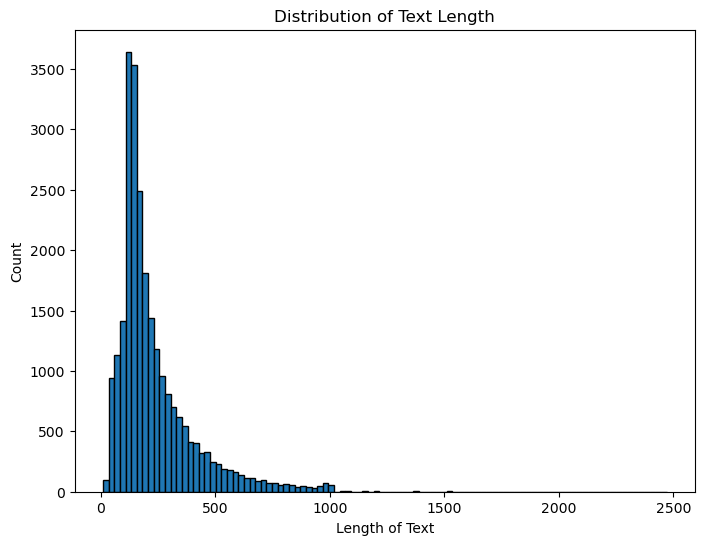

Min: 10
Max: 2470


In [48]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Map each sample to its number of words and create a new dataset
num_words = dataset_train_original.map(lambda x, y: tf.shape(tf.strings.split(x))[0])

# Convert to a NumPy array using as_numpy_iterator
num_words = list(tfds.as_numpy(num_words))

# Create a histogram of the number of words with 100 bins and adjust the spacing between the bins
plt.hist(num_words, bins=100, edgecolor='black')

# Set the x and y axis labels
plt.title('Distribution of Text Length')
plt.xlabel('Length of Text')
plt.ylabel('Count')

# Show the plot
plt.show()
print('Min:', np.min(num_words))
print('Max:', np.max(num_words))

### Check out "outliers"

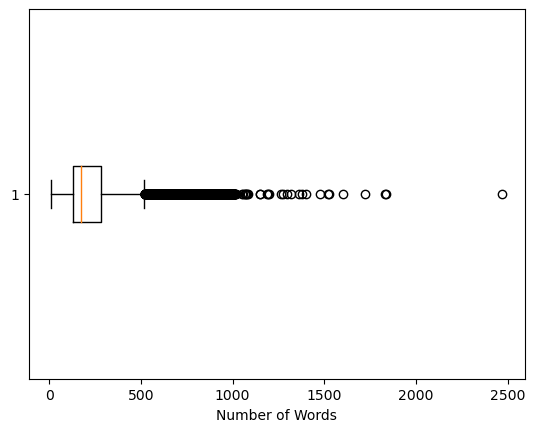

In [49]:
# Map each sample to its number of words and create a new dataset
num_words = dataset_train_original.map(lambda x, y: tf.shape(tf.strings.split(x))[0])

# Convert to a NumPy array using as_numpy_iterator
num_words = list(tfds.as_numpy(num_words))

# Create a box plot of the number of words
plt.boxplot(num_words, vert=False)

# Set the x and y axis labels
plt.xlabel('Number of Words')
plt.ylabel('')

# Show the plot
plt.show()

## Bag of Words Encoding

In [50]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='multi_hot'
)
encoder.adapt(
    dataset_train_original.map(lambda text, label: text).batch(2048)
)

2023-02-12 17:25:38.896286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Check how the text looks like

In [51]:
text1 = 'A beginning is a very delicate time.'
print(text1)

text_encoded1 = encoder(text1)
print(text_encoded1)

A beginning is a very delicate time.
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(10000,), dtype=float32)


---
## Train the first model

In [52]:
dataset_train = dataset_train_original.cache()  # cache all the time
dataset_train = dataset_train.shuffle(25_000) 
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.cache()
dataset_validate = dataset_validate.batch(128)

In [53]:
model_1 = models.Sequential()
model_1.add(encoder)
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 10000)            0         
 ectorization)                                                   
                                                                 
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [54]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)
model_1.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [55]:
model_1.fit(
    dataset_train,
    epochs=20,
    validation_data = dataset_validate,
)

Epoch 1/20


2023-02-12 17:25:40.223423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8632

2023-02-12 17:25:44.678622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 6s 31ms/step - loss: 0.3192 - accuracy: 0.8632 - val_loss: 0.2879 - val_accuracy: 0.8794
Epoch 2/20
196/196 [==============================] - 5s 23ms/step - loss: 0.1541 - accuracy: 0.9380 - val_loss: 0.3528 - val_accuracy: 0.8686
Epoch 3/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0674 - accuracy: 0.9750 - val_loss: 0.4495 - val_accuracy: 0.8652
Epoch 4/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0253 - accuracy: 0.9919 - val_loss: 0.6152 - val_accuracy: 0.8658
Epoch 5/20
196/196 [==============================] - 5s 23ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.7247 - val_accuracy: 0.8658
Epoch 6/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.8419 - val_accuracy: 0.8608
Epoch 7/20
196/196 [==============================] - 5s 25ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.8729 - val_accuracy: 0.8643
Epoch 8/20

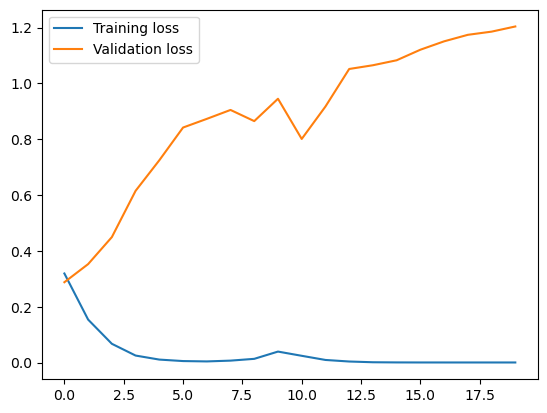

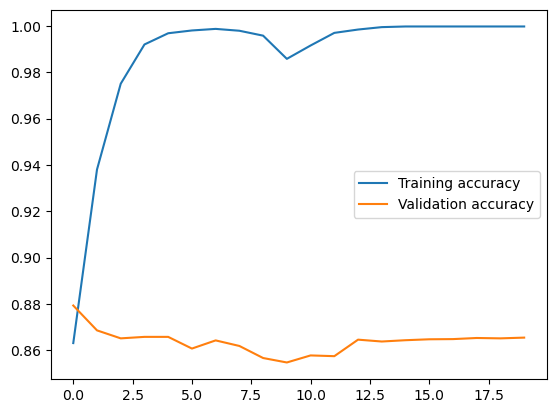

In [56]:
plot_history_plus(model_1.history.history)

In [57]:
dataset_test = dataset_test_original.cache()
dataset_test = dataset_test.batch(128)
test_loss, test_metric = model_1.evaluate(dataset_test)
print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")

98/98 [==============================] - 2s 16ms/step - loss: 1.2158 - accuracy: 0.8646
Test Loss: 1.2157641649246216, Test Metric: 0.864560067653656


### Make some predictions

In [58]:
# Make a prediction on a new example text
new_texts = ['This movie was really great, I enjoyed it a lot.', 'This movie was terrible, I hated it.']

prediction = model_1.predict(new_texts)

# Print the prediction
print(prediction)

# Convert the predicted probability to a binary label
predicted_label = np.round(prediction).astype(int)

# Print the predicted label
print(predicted_label)

1/1 [==============================] - 0s 99ms/step
[[9.9999976e-01]
 [3.7401499e-06]]
[[1]
 [0]]


2023-02-12 17:27:19.139459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


---
## Make the Second Model with a Embedding layer

In [59]:
vocabulary_size = 10_000
sequence_length = 128
encoder_3 = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length = sequence_length,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int'
)
encoder_3.adapt(
    dataset_train_original.map(lambda text, label: text).batch(2048)
)

2023-02-12 17:27:19.265368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [60]:
vocabulary = encoder_3.get_vocabulary()
print(vocabulary[:100])
texttry = 'Is this real? Too fantasy!'
print(texttry)
texttry_encode = encoder_3(texttry)
print(texttry_encode)  # the position
vocabulary.index('queen')

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she', 'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really', 'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because', 'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most', 'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could', 'way', 'them', 'any']
Is this real? Too fantasy!
tf.Tensor(
[  7  11 146 100 996   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0


1600

In [61]:
model_3 = models.Sequential()
model_3.add(encoder_3)
model_3.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 128, 32)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               2097664   
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,418,177
Trainable params: 2,418,177
Non-trainable params: 0
____________________________________________

Epoch 1/20


2023-02-12 17:27:21.079188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7350

2023-02-12 17:27:27.403662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 8s 37ms/step - loss: 0.4974 - accuracy: 0.7350 - val_loss: 0.3784 - val_accuracy: 0.8294
Epoch 2/20
196/196 [==============================] - 6s 28ms/step - loss: 0.1724 - accuracy: 0.9355 - val_loss: 0.4988 - val_accuracy: 0.7977
Epoch 3/20
196/196 [==============================] - 5s 26ms/step - loss: 0.0226 - accuracy: 0.9950 - val_loss: 0.7149 - val_accuracy: 0.8023
Epoch 4/20
196/196 [==============================] - 5s 24ms/step - loss: 0.0021 - accuracy: 0.9999 - val_loss: 0.8059 - val_accuracy: 0.8068
Epoch 5/20
196/196 [==============================] - 5s 23ms/step - loss: 5.1101e-04 - accuracy: 1.0000 - val_loss: 0.8523 - val_accuracy: 0.8078
Epoch 6/20
196/196 [==============================] - 5s 24ms/step - loss: 2.9375e-04 - accuracy: 1.0000 - val_loss: 0.8825 - val_accuracy: 0.8090
Epoch 7/20
196/196 [==============================] - 5s 25ms/step - loss: 2.0212e-04 - accuracy: 1.0000 - val_loss: 0.9092 - val_accuracy: 0.809

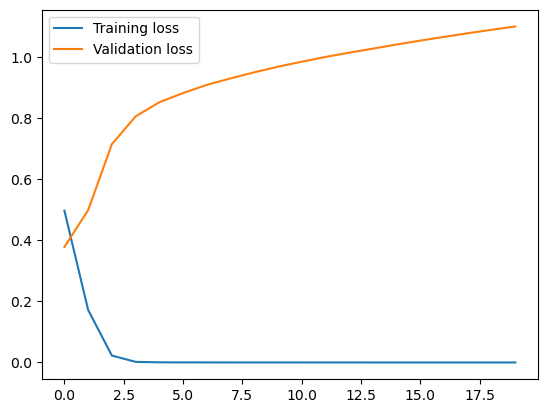

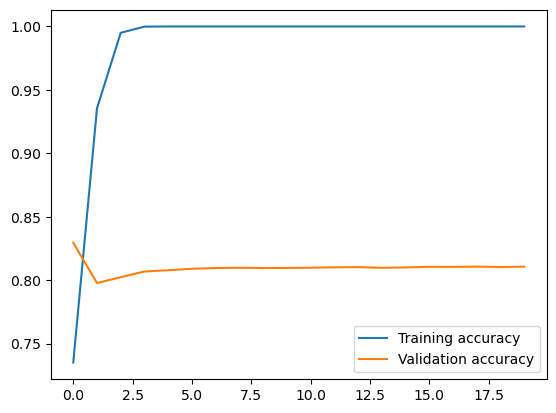

In [62]:
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_3.fit(
    dataset_train,
    epochs=20,
    validation_data = dataset_validate,
)
plot_history_plus(model_3.history.history)

In [63]:
dataset_test = dataset_test_original.cache()
dataset_test = dataset_test.batch(128)
model_3.evaluate(dataset_test)

98/98 [==============================] - 1s 10ms/step - loss: 1.1402 - accuracy: 0.8003


[1.1401865482330322, 0.800320029258728]

In [64]:
# Make a prediction on a new example text
new_texts = ['This movie was really great, I enjoyed it a lot.', 'This movie was terrible, I hated it.']

prediction = model_1.predict(new_texts)

# Print the prediction
print(prediction)

# Convert the predicted probability to a binary label
predicted_label = np.round(prediction).astype(int)

# Print the predicted label
print(predicted_label)

1/1 [==============================] - 0s 65ms/step
[[9.9999976e-01]
 [3.7401499e-06]]
[[1]
 [0]]


- bad embedding makes the predictions worse, therefore we need a good vectorization model